## Board Games - Recommender System

**The goal here is to create a supervised personalized recommendation system using collaborative filtering**

- **Recommendation Systems** (also known as recommendation engines) are a relatively new prediction method that uses algorithms such as **Collaborative filtering** (CF) and Clustering that try to provide a number N of items (not yet interacted) for a specific user based on the correlation between users and what they had interaction with. In our case we initially try to implement a CF using a dataset with over 15 million rows. These reviews were scraped from https://boardgamegeek.com/ and can be found [here](https://www.kaggle.com/jvanelteren/boardgamegeek-reviews?select=bgg-15m-reviews.csv)!

> **Offering some context to board games**, the definition is pretty open, but normally the rules are clear, needs a mechanic to use during the game and some sort of definition of how someone can win in that game. We can find games that uses pieces, boards, cards, dice, coins, resources and nowadays we even have eletronics involved in board games.

![image]("../capimages/board_game_cafe.jpg")

> **Our data consists with 3 different datasets:**
>- **bgg_reviews**: Board Game Geek reviews with over 15 million entries, counts with rating, comments from a user towards a specific game.
>- **games**: With information on over 19 thousand games. Counts with 56 columns, among these it has the year published, the weight (a kind of measure of difficulty), board game designer, minumum and maximum amount of players and the playing time.
>- **reviews_summary**: It has all the information of the first dataset in a summarized way.

For this notebook we decided to use only the first two datasets.

In [1]:
import random
import pickle
import pandas as pd
from math import sqrt
import seaborn as sns
from surprise import accuracy
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise import Reader, Dataset, SVD
from surprise.prediction_algorithms import knns
from sklearn.metrics import mean_absolute_error
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.similarities import cosine, msd, pearson
import warnings; warnings.simplefilter('ignore')


bgg_reviews = pd.read_csv('../../../bgg-15m-reviews.csv')
games = pd.read_csv('../../../games_detailed_info.csv')
reviews_summary = pd.read_csv('../../../2020-08-19.csv')

### Bring useful functions to the data exploration

In [2]:
def basic_info(data):
    """
    Gets basic information to understand more of the data, also useful to delete columns that we know are categorical
    """
    print("Dataset shape is: ", data.shape)
    print("Dataset size is: ", data.size)
    print(data.duplicated().sum())
    print("Dataset columns are: ", data.columns)
    print("Dataset info is: ", data.info())
    categorical = []
    numerical = []
    for i in data.columns:
        if data[i].dtype == object:
            categorical.append(i)
        else:
            numerical.append(i)
    print("Categorical variables are:\n ", categorical)
    print("Numerical variables are:\n ", numerical)
    return categorical, numerical

In [3]:
def columns_w_nan(data, y=0.4):
    """
    Returns the columns that have NaN values and it's percentage related to the total number;
    Also returns a list with the name(s) of the columns that have y% made out of missing value.
    """
    
    temp = []
    temp_perce = []
    for x in data.columns:
        if data[x].isna().sum() > 0:
            percentage_of_data = data[x].isna().sum()/(list(data.shape)[0])
            print("Row: {} : is made {}% of NaN Values.".format(x, percentage_of_data.round(3)))
            if percentage_of_data > y:
                temp.append(x)
                temp_perce.append(percentage_of_data)
    if len(temp) > 0:
        print('These are the columns that have a considerable amount of NaN values:')            
        print(temp)
    elif data.isna().sum().sum() != 0:
        print('You might still have some NaN values')
    else:
        print('No NaN Values found')

### First analysis of "bgg_reviews" dataset

In [4]:
basic_info(bgg_reviews)

Dataset shape is:  (15823269, 6)
Dataset size is:  94939614
0
Dataset columns are:  Index(['Unnamed: 0', 'user', 'rating', 'comment', 'ID', 'name'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15823269 entries, 0 to 15823268
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 724.3+ MB
Dataset info is:  None
Categorical variables are:
  ['user', 'comment', 'name']
Numerical variables are:
  ['Unnamed: 0', 'rating', 'ID']


(['user', 'comment', 'name'], ['Unnamed: 0', 'rating', 'ID'])

In [5]:
columns_w_nan(bgg_reviews, 0.3)

Row: user : is made 0.0% of NaN Values.
Row: comment : is made 0.811% of NaN Values.
These are the columns that have a considerable amount of NaN values:
['comment']


In [6]:
bgg_reviews.head(3)

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic


In [7]:
# We drop comment since it has so many NaN values and Unnamed that we see is a duplicate of the index
bgg_reviews.drop(columns=['comment', 'Unnamed: 0'], inplace=True)

In [8]:
# We now drop the remaining NaN values that exist on the 0%, since having user is fundamental for our analysis
bgg_reviews.dropna(inplace=True)

### First analysis of "games" dataset

In [9]:
basic_info(games)

Dataset shape is:  (19230, 56)
Dataset size is:  1076880
0
Dataset columns are:  Index(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage',
       'suggested_language_dependence', 'playingtime', 'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic',
       'boardgamefamily', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher',
       'usersrated', 'average', 'bayesaverage', 'Board Game Rank',
       'Strategy Game Rank', 'Family Game Rank', 'stddev', 'median', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments', 'numweights',
       'averageweight', 'boardgameintegration', 'boardgamecompilation',
       'Party Game Rank', 'Abstract Game Rank', 'Thematic Rank',
       'War Game Rank', 'Customizable Rank', 'Children's Game Rank',
       '

(['type',
  'thumbnail',
  'image',
  'primary',
  'alternate',
  'description',
  'suggested_num_players',
  'suggested_playerage',
  'suggested_language_dependence',
  'boardgamecategory',
  'boardgamemechanic',
  'boardgamefamily',
  'boardgameexpansion',
  'boardgameimplementation',
  'boardgamedesigner',
  'boardgameartist',
  'boardgamepublisher',
  'boardgameintegration',
  'boardgamecompilation'],
 ['Unnamed: 0',
  'id',
  'yearpublished',
  'minplayers',
  'maxplayers',
  'playingtime',
  'minplaytime',
  'maxplaytime',
  'minage',
  'usersrated',
  'average',
  'bayesaverage',
  'Board Game Rank',
  'Strategy Game Rank',
  'Family Game Rank',
  'stddev',
  'median',
  'owned',
  'trading',
  'wanting',
  'wishing',
  'numcomments',
  'numweights',
  'averageweight',
  'Party Game Rank',
  'Abstract Game Rank',
  'Thematic Rank',
  'War Game Rank',
  'Customizable Rank',
  "Children's Game Rank",
  'RPG Item Rank',
  'Accessory Rank',
  'Video Game Rank',
  'Amiga Rank',
  'Co

In [10]:
columns_w_nan(games, 0.5)

Row: thumbnail : is made 0.001% of NaN Values.
Row: image : is made 0.001% of NaN Values.
Row: alternate : is made 0.6% of NaN Values.
Row: description : is made 0.0% of NaN Values.
Row: suggested_playerage : is made 0.122% of NaN Values.
Row: suggested_language_dependence : is made 0.134% of NaN Values.
Row: boardgamecategory : is made 0.011% of NaN Values.
Row: boardgamemechanic : is made 0.081% of NaN Values.
Row: boardgamefamily : is made 0.233% of NaN Values.
Row: boardgameexpansion : is made 0.751% of NaN Values.
Row: boardgameimplementation : is made 0.787% of NaN Values.
Row: boardgamedesigner : is made 0.022% of NaN Values.
Row: boardgameartist : is made 0.281% of NaN Values.
Row: Strategy Game Rank : is made 0.892% of NaN Values.
Row: Family Game Rank : is made 0.896% of NaN Values.
Row: boardgameintegration : is made 0.926% of NaN Values.
Row: boardgamecompilation : is made 0.964% of NaN Values.
Row: Party Game Rank : is made 0.97% of NaN Values.
Row: Abstract Game Rank : is

In [11]:
# We drop the columns that we don't plan to use for now, another reason would be the high number of NaN values
games = games.drop(columns=['Unnamed: 0', 'alternate', 'boardgameexpansion', 'boardgameimplementation',
                            'Strategy Game Rank', 'Family Game Rank', 'boardgameintegration',
                            'boardgamecompilation', 'Party Game Rank', 'Abstract Game Rank',
                            'Thematic Rank', 'War Game Rank', 'Customizable Rank', "Children's Game Rank",
                            'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
                            'Commodore 64 Rank', 'Arcade Rank', 'Atari ST Rank'])
games.dropna(inplace=True)

In [12]:
# And that's how it looks like:
games.head(3)

,type,id,thumbnail,image,primary,description,yearpublished,minplayers,maxplayers,suggested_num_players,...,Board Game Rank,stddev,median,owned,trading,wanting,wishing,numcomments,numweights,averageweight
0,boardgame,30549,https://cf.geekdo-images.com/thumb/img/HEKrtpT...,https://cf.geekdo-images.com/original/img/j-pf...,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,"[OrderedDict([('@numplayers', '1'), ('result',...",...,91,1.32632,0,144727,2191,640,8571,15778,5232,2.4148
1,boardgame,822,https://cf.geekdo-images.com/thumb/img/kqE4YJS...,https://cf.geekdo-images.com/original/img/o4p6...,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,"[OrderedDict([('@numplayers', '1'), ('result',...",...,173,1.30369,0,140066,1587,539,6286,17720,7304,1.9158
2,boardgame,13,https://cf.geekdo-images.com/thumb/img/g8LvJsd...,https://cf.geekdo-images.com/original/img/A-0y...,Catan,"In Catan (formerly The Settlers of Catan), pla...",1995,3,4,"[OrderedDict([('@numplayers', '1'), ('result',...",...,381,1.47908,0,144656,1825,474,5310,17859,7187,2.3264


In [13]:
# That's our first EDA and preprocessing of the data
# We set random_state for reproducibility.
bgg_reviews.sample(3, random_state=22)

,user,rating,ID,name
13907171,DeanMary,8.0,6137,Drive
147029,DarrylFerster,10.0,10630,Memoir '44
13243091,Scubaroo,8.0,175695,Minerva


- Since we do not plan to use comments (in reality those are qualitative reviews) for now and they have a lot of missing values (around 80%), we drop them.
- We also drop 'Unnamed: 0' because we notice it is a repeat of the index.
- The other column we are going to drop in the future is the 'ID', because it is represented already by 'name'.

We went to the website to verify if it was safe to drop ID or if it was assigned at random on the making of the dataset:

![title](../capimages/kingoftokyo.jpg)

King of Tokyo = 70323, we are good to go. (Great game by the way, and one of the coolest dice I have ever seen)

### With the data cleaner we can move on to understand more of our data.

**How about what are the games with the biggest number of reviews in the website?**

Text(0, 0.5, 'Name of the Boardgame')

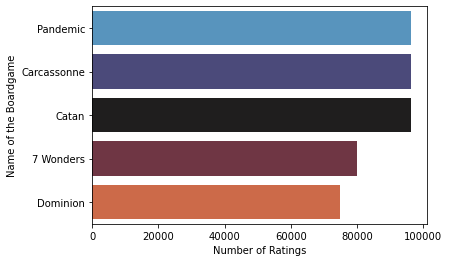

In [14]:
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
ax = sns.barplot(x=list(bgg_reviews['name'].value_counts()[0:5]),
                 y=bgg_reviews['name'].value_counts()[0:5].keys(), data=bgg_reviews, palette="icefire")
ax.set_xlabel('Number of Ratings')

ax.set_ylabel("Name of the Boardgame")

- Close fight on top 3! Catan and Carcassone are classics from the 2000's while Pandemic and 7 Wonders came a little bit after that.

**How is the distribuition of number of reviews?**

Text(0.5, 1.0, 'Distribuition of reviews by game')

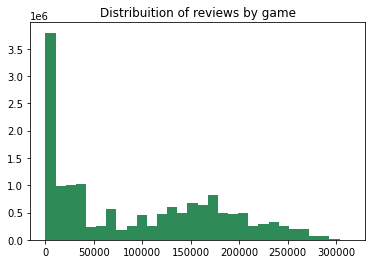

In [15]:
# Number of reviews destribuition. We can see that we have the majority of the games with "low" number of reviews
plt.hist(bgg_reviews['ID'], bins=30, color='seagreen', log=False)
plt.title('Distribuition of reviews by game')

- Like we would suspect: It is skewed to the right, meaning just a few had a huge amount of reviews/votes, forming the well known long-tail.

In [16]:
# Looking at how much low and high number of reviews actually are:
bgg_reviews['ID'].value_counts().describe()
# We can see that the 75% is actually 378, but the mean is 818. Meaning we have some outliers bringing the value upwards.

count    19330.000000
mean       818.582669
std       3370.681916
min         30.000000
25%         55.000000
50%        119.000000
75%        378.000000
max      96234.000000
Name: ID, dtype: float64

**Another important feature in games is the "weight", that is how complicated a game is:**


There is a well-known bias to give higher ratings to more complex games. That could be for several reasons that we are not even going to try to guess, but we should check for that in case we want to use on a more precise recommendation.

In [17]:
# Using describe we can have a quick overview of the values, the mean and the 75% percentile are pretty close, which 
# once again points to some outliers to higher numbers
games['averageweight'].describe()

count    8819.000000
mean        2.216246
std         0.828627
min         0.000000
25%         1.564800
50%         2.142900
75%         2.771400
max         4.900000
Name: averageweight, dtype: float64

In [18]:
bgg_reviews['rating'].describe()

count    1.582320e+07
mean     7.054855e+00
std      1.599638e+00
min      1.401300e-45
25%      6.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

- As we can see it seems to have a relationship, but to visualize that we need to get the dataset together

**Since the information we need is in 2 different tables, lets join them together so we can analyze the rating per weights**

In [19]:
# We first get the columns from "games" that we are interested, subsetting the bigger dataset
games_weight = games[['id', 'averageweight', 'boardgamedesigner', 'thumbnail', 'image', 'primary']]

In [20]:
# We rename 'primary' to 'name', so the merge can happen more smoothly
games_weight.columns = ['id', 'averageweight', 'boardgamedesigner', 'thumbnail', 'image', 'name']

In [21]:
# We rename the "ID" to "id" on the bgg_reviews dataset:
bgg_reviews.columns = ['user', 'rating', 'id', 'name']

In [22]:
rating_weight = bgg_reviews.merge(games_weight)

In [23]:
# We verify the highest Weight of a game
rating_weight.averageweight.max()

4.9

In [24]:
# To both "Weight" and "Rating" be on the same scale, we multiply the weight by 2
rating_weight['averageweight'] = rating_weight['averageweight']*2

In [25]:
# For a quick analysis we drop the user column and create a new dataset because we might use the first one in the future
rating_weight_comparison = rating_weight.drop(columns=['user'])

In [26]:
rating_weight_comparison = rating_weight_comparison.groupby('name').mean()

In [27]:
rating_weight_comparison =  rating_weight_comparison.sort_values(by='averageweight', ascending=True)

In [28]:
# For some reason there are some 0's on weights - lets assume they are mistakes and remove them
rating_weight_comparison['averageweight'] = rating_weight_comparison['averageweight'].where(rating_weight_comparison['averageweight'] > 0)

In [29]:
rating_weight_comparison.dropna(inplace=True)

In [30]:
rating_weight_comparison.head(3)

,rating,id,averageweight
name,,,
Frankenstein,6.294944,151046.808989,1.011236
Monte Rolla,5.819149,11972.000000,2.000000
Micro Monsters,6.619481,100795.000000,2.000000


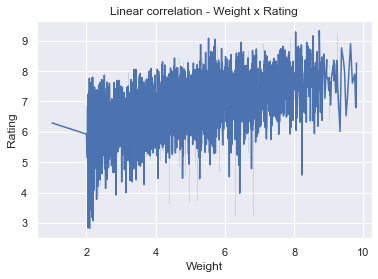

In [31]:
sns.set_theme(style="darkgrid")
fig = sns.lineplot(x="averageweight", y="rating",
             data=rating_weight_comparison)
plt.xlabel("Weight")
plt.ylabel("Rating")
plt.title("Linear correlation - Weight x Rating")
plt.show(fig)

- This kind of line graph is more descriptive but harder to see, let's try something else:

In [32]:
# Here we use cut to bin the values so we can have a more clean data to visualize
rating_weight_comparison['bin_rating'] = pd.cut(rating_weight_comparison['rating'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=False)

In [33]:
rating_weight_comparison['bin_weight'] = pd.cut(rating_weight_comparison['averageweight'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=False)

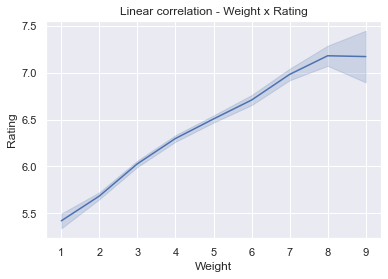

In [34]:
fig = sns.lineplot(data=rating_weight_comparison, x="bin_weight", y="bin_rating")
plt.xlabel("Weight")
plt.ylabel("Rating")
plt.title("Linear correlation - Weight x Rating")
plt.show(fig)

- We can see that there is a trend going upwards, where the highest rated games are at least 5(In a scale out of 1-10 in difficulty). But something important to notice is that it seems to exist a risk-reward situation, in both ends (being too easy or too hard) that might also play a factor.

**We are going to make also a filter for the recommendation system based on the WEIGHT for basically two reasons:**
- Remove the bias - what is the best game for that person that has X weight.
- Provide a more personalized recommendation, the person decide how hard the game he/she is going to receive, we are not always in the mood to play a super hard game but sometimes that is exactly what we are looking for.

### Let's get our data ready for our modeling

In [35]:
# We change the name of the columns to follow more of a pattern and be more descriptive
bgg_reviews.columns = ['user_id', 'rating', 'game_id', 'name']

In [36]:
# We subset our data for being easier on the processing of the model
bgg_reviews = bgg_reviews.sample(1800000 , random_state=22)

- We decide to filter our data even further, based on the number of reviews.
- The explanation for this is that this might improve the performance of the model by only having users with contribution enough that have actual value for the modeling.

In [37]:
# We decide setting the threshold at 8, based on the percentile(75%):
bgg_reviews['user_id'].value_counts().describe()

count    225367.000000
mean          7.986972
std          14.270001
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         680.000000
Name: user_id, dtype: float64

In [38]:
number_filter = bgg_reviews.groupby('user_id')['rating']
number_filter = pd.DataFrame(number_filter.count())

In [39]:
list_users = number_filter[number_filter['rating'] >= 8].index
bgg_reviews =  bgg_reviews[bgg_reviews['user_id'].isin(list_users)]

- Now we have a smaller but better dataset.

In [40]:
# Drop the column 'name' since we can use the ID and inplace=True so we keep our changes
bgg_reviews.drop(columns=['game_id'], inplace=True)

In [41]:
# Sample of our data again to check how our data looks like
bgg_reviews.sample(3, random_state=22)

,user_id,rating,name
13324509,Donald13,8.5,The World Cup Game
7277457,leobetosouza,6.0,Elysium
7632114,tribefan07,7.5,Cacao


In [42]:
# Now we have to rearrange the columns to a form that the model understand, that is:
cols = ['user_id', 'name', 'rating']
bgg_reviews = bgg_reviews[cols]

**Here we have our data ready to feed to whatever model we decide to use, but to make it lighter on the modeling we decide to use only a fraction of the whole data for now**:

The data is sorted by game, which we should pay attention to the way we will get the data so we keep a "healthy" ratio of number of users and items

In [43]:
"The number of board games is: {}, and {} of users".format(len(bgg_reviews['name'].unique()),
                                                           len(bgg_reviews['user_id'].unique()))

'The number of board games is: 18777, and 62696 of users'

The porportion is around 3.3 users for every 1 board game, so it is an item-item similarity situation.

In [46]:
# What is the mean of the ratings?
bgg_reviews['rating'].mean()

6.897314802672811

## For our modeling we try different approaches to find the best one:


We need to instatiate Reader to transform our dataset into a form that the library (Surprise) can read.

In [47]:
# We need to specify the range for the rating scale, since the default is 1 to 5
reader = Reader(rating_scale=(1,10))

In [48]:
# We transform the dataset into a surprise-dataset
data = Dataset.load_from_df(bgg_reviews, reader)

In [49]:
# We run train-test split on the data so we can validate it later
trainset, testset = train_test_split(data, test_size=0.25, random_state=22)

In [50]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  62696 

Number of items:  18543 



**We first try cosine similarity**

In [51]:
# Here we define that we want cosine similarity approach and set the user_based to false, since we have more users than items
sim_cos = {'name':'cosine', 'user_based':False}

In [52]:
# We set the model (KNN) and use the sim_cos defined before
basic = knns.KNNBasic(sim_options=sim_cos)

In [53]:
# We fit the model
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [54]:
# We get the predictions of our first model
predictions = basic.test(testset)

In [55]:
# And this is what it looks like one prediction
predictions[0]

Prediction(uid='Siroj', iid='Trajan', r_ui=8.0, est=7.332369499041609, details={'actual_k': 6, 'was_impossible': False})

In [56]:
# The accuracy that we are going to use is RMSE(root-mean-square error), but you can also use
# MAE(Mean Absolute Error) and FCP(Fraction of Concordant Pairs).
print(accuracy.rmse(predictions))

RMSE: 1.5014
1.5013697486706932


**Now we try pearson correlation**

In [57]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [58]:
print(accuracy.rmse(predictions))

RMSE: 1.5582
1.5581676173341248


It seems that cosine similarity is better for our situation, but lets try pearson with knn with means instead of the vanilla version:

In [59]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)


Computing the pearson similarity matrix...
Done computing similarity matrix.


In [60]:
print(accuracy.rmse(predictions))

RMSE: 1.3691
1.3690942538127555


And now Pearson with Baseline:

In [61]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [62]:
print(accuracy.rmse(predictions))

RMSE: 1.3577
1.357696396493476


This is the best result so far! But lets keep moving.

### We can also try Model-Based methods instead of Memory-Based

SVD is the most well-known algorithm

In [63]:
# We ran gridsearch to find these parameters - it's in the other notebook in this repository if you want to take a look
svd = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4, verbose=False)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.3117
1.3116574399175387


- This is a great score, can be translated as 1.31 out of a 10.

### Lets see how our predictions actually work!

In [64]:
bgg_reviews.sample(5, random_state=22)

,user_id,name,rating
13324509,Donald13,The World Cup Game,8.5
7277457,leobetosouza,Elysium,6.0
7632114,tribefan07,Cacao,7.5
5691093,KatsuIas,Harry Potter: Hogwarts Battle,8.0
10639613,_mrq_,Illuminati,6.5


In [65]:
# What user 319493 thinks of game 1?
svd.predict('leobetosouza', 'Elysium')

Prediction(uid='leobetosouza', iid='Elysium', r_ui=None, est=7.067911160885226, details={'was_impossible': False})

In [66]:
svd.predict('leobetosouza', 'Cacao')

Prediction(uid='leobetosouza', iid='Cacao', r_ui=None, est=6.954608523251118, details={'was_impossible': False})

In [67]:
svd.predict('KatsuIas', 'Harry Potter: Hogwarts Battle')

Prediction(uid='KatsuIas', iid='Harry Potter: Hogwarts Battle', r_ui=None, est=7.605735747785954, details={'was_impossible': False})

- As we can see our model is working great. Not only express how a user would feel about a game but also is really precise when try to guess a rating for a game that someone already voted for. But of course, still have space for improvement.

### Recommendation based on each user using collaborative filtering

Here we develop how our final algorithm is going to look like. You get recommendations back based on the username!

In [68]:
# We map the predictions for each single user and then get the highest predicted ratings for those games
def get_top_n(predictions, n=5):
    """
    Return the top-N recommendation for each user from a set of predictions.
    """
    
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
      
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [69]:
def recommendation_nickname(user):
    user_games = []
    top_n = get_top_n(predictions)
    for uid, user_ratings in top_n.items():
        if uid == user:
            user_games.append((uid, [iid for (iid, _) in user_ratings]))
    if len(user_games[0][1]) > 2:
        print("These are your recommendations of games you might like:")
        return user_games[0][1]
    elif len(user_games[0][1]) < 3:
        print("Did you know, the more games you review, the better our recommendation system works?")
        return user_games[0][1]
    else:
        print("Error: It seems like we don't have enough data on you - It could be a typo, \
              or a problem on our end - Please send us an e-mail with the screenshot on: the.new.recommender@gmail.com")
        

In [70]:
recommendation_nickname('jollyfulpanda')

These are your recommendations of games you might like:


['Raptor',
 'Santorini',
 'No Thanks!',
 'One Night Ultimate Werewolf',
 "Ca$h 'n Guns (Second Edition)"]

## Next Steps and Level Up!

**Here we set some goals to keep working in the future and try different methods**

### Recommendation based on designer

Here we try something different, I wanted to make some sort of recommendation based solely on the board game designer.
Since us (the board gamers) are still developing a sense of categories for boardgames and trying to bin them more together, a great way to distinguish the mechanic of the game is by the designer.

In [71]:
temp_df = pd.read_csv('../../../bgg-15m-reviews.csv')

In [72]:
temp_df.drop(columns=['comment', 'Unnamed: 0'], inplace=True)
temp_df.dropna(inplace=True)
temp_df.columns = ['user', 'rating', 'id', 'name']

In [73]:
rat_wei_designer = temp_df.merge(games_weight)

In [74]:
def get_recommendations(nickname):
    
    """ Recommendation based on the "favorite" designer of a person. 
    If the user doesn't have a votes or if it played all the games that the designer made the
    recommendation will suggest the most popular games instead. """
    
    error_counter = []
    temp_dataset = rat_wei_designer[rat_wei_designer['user'] == str(nickname)].sort_values(by='rating', ascending=False)
    if len(temp_dataset) > 0:
        temp_dataset_2 = temp_dataset[0:(len(temp_dataset)//2)]
    else:
        error_counter += 1 
    
    list_of_designers = list(temp_dataset_2['boardgamedesigner'].unique())
    list_of_games = list(temp_dataset_2['name'].unique())
    
    list_of_designers = list_of_designers[0:3]
    
    list_designer_based = []
    list_designer_based_final = []
    
    for designer_name in list_of_designers:
        list_designer_based.append(list(rat_wei_designer[rat_wei_designer.boardgamedesigner == designer_name]['name'].unique()))
    
    for x in list_designer_based:
        for y in x:
            if y not in list_of_games:
                list_designer_based_final.append(y)
    
    
    if len(list_designer_based_final) > 1:
        print("These are your recommendations of games based on the designer(s) you seem to like:")
    elif len(list_designer_based_final) < 2:
        print("Did you know, the more games you review, the better our recommendation system works?")
    else:
        print("Error: It seems like we don't have enough data on you - It could be a typo, or a problem on our end - Please send us an e-mail with the screenshot please on: the.new.recommender@gmail.com")
    return random.sample(list_designer_based_final, 5)
    
    #return list_of_games
    #return recommendation_designer_based

In [81]:
get_recommendations('Ichiruishu')

These are your recommendations of games based on the designer(s) you seem to like:


['Ghooost!',
 'King of New York',
 'Mole Rats in Space',
 'Forbidden Island',
 'KeyForge: Age of Ascension',
 'Forbidden Desert']

### Saving the model using Pickle

In [76]:
filename = 'model_final.sav'

In [77]:
pickle.dump(svd, open(filename, 'wb'))

In [78]:
loaded_model = pickle.load(open(filename, 'rb'))

In [79]:
result = loaded_model.predict('KatsuIas', 'Harry Potter: Hogwarts Battle')

In [80]:
result

Prediction(uid='KatsuIas', iid='Harry Potter: Hogwarts Battle', r_ui=None, est=7.605735747785954, details={'was_impossible': False})